In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import utils
import knn_validation

In [2]:
x = pd.read_csv("../Data_Crowdsourced_Mapping/training.csv",sep=",")
X = x.drop(columns=["class"])
y = x["class"]
x = pd.read_csv("../Data_Crowdsourced_Mapping/testing.csv",sep=",")
X_test = x.drop(columns=["class"])
y_test = x["class"]

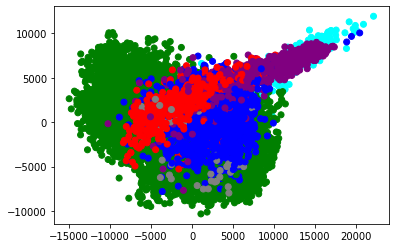

In [3]:
utils.plot_clustering(data=X,labels=y)
plt.show()

In [4]:
cls = KNeighborsClassifier(n_neighbors=1)
cls.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [5]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y,stratify=y, train_size=0.90,random_state=42)

In [6]:
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('nca',
                 NeighborhoodComponentsAnalysis(callback=None, init='auto',
                                                max_iter=50, n_components=None,
                                                random_state=42, tol=1e-05,
                                                verbose=0, warm_start=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1, p=2,
                                      weights='uniform'))],
         verbose=False)

In [7]:
print(nca_pipe.score(X_validation, y_validation))

1.0


In [8]:
y_pred = nca_pipe.predict(X_test)
accuracy_score(y_pred, y_test)

0.5866666666666667

Détermine le nombre optimal de voisin $K_{opt}$ pour le jeux de données 

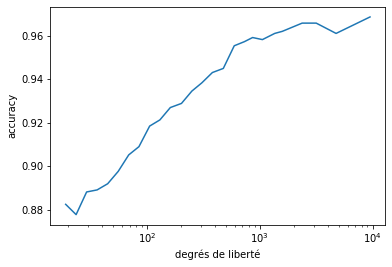

1

In [9]:
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500,30)).astype(int))
gen = knn_validation.knn_simple_validation(X_train, y_train, X_validation, y_validation,n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy", "degrés de liberté"])
sp = sns.lineplot(x="degrés de liberté", y="accuracy", data=df)
sp.set(xscale="log")
plt.show() 
Kopt = df.loc[df.accuracy.idxmax(), "# neighbors"]
Kopt

In [10]:
cls = KNeighborsClassifier(n_neighbors=Kopt)
cls.fit(X,y)
y_pred = cls.predict(X_test) 
accuracy_score(y_pred, y_test)

0.5866666666666667

L'espace des hyperparamètre est très grand et si le nombre données est trop petit; le nombre de voisin optimal obetnu peut ne pas correspondre. Pour y faire face on peut recommencer en modifiant les données de validation et de tests.

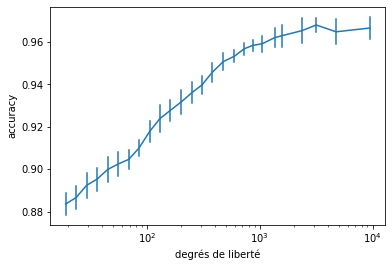

2

In [11]:
train_size = 0.90
n_splits = 10
gen = knn_validation.knn_multiple_validation(X, y, n_splits, train_size,n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy", "degrés de liberté"])
sp = sns.lineplot(x="degrés de liberté", y="accuracy",err_style="bars", ci="sd", data=df)
sp.set(xscale="log")
plt.show() 
Kopt = df.loc[df.accuracy.idxmax(), "# neighbors"]
Kopt

In [12]:
cls = KNeighborsClassifier(n_neighbors=Kopt)
cls.fit(X,y)
y_pred = cls.predict(X_test) # nombre de voisin 3
accuracy_score(y_pred, y_test)

0.55

In [13]:
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500,30)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}
cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X, y)
search.best_params_

{'n_neighbors': 9}

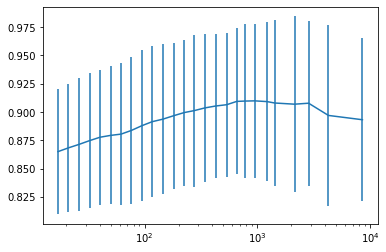

In [14]:
df = pd.DataFrame(
    (
    dict(n_neighbors=d["n_neighbors"], error=e, std=s)
    for d, e, s in zip(
        search.cv_results_["params"],
        search.cv_results_["mean_test_score"],
        search.cv_results_["std_test_score"],
    )
    )
)
n = 9/10 * len(y_train)
plt.errorbar(n/df["n_neighbors"], df["error"], yerr=df["std"])
plt.xscale("log")
plt.show()

In [15]:
y_pred = search.predict(X_test)
accuracy_score(y_pred, y_test)

0.6233333333333333